<a href="https://colab.research.google.com/github/krithikajain/imageClustering/blob/main/kmeans_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import cv2

In [71]:
# loading the data file
data=pd.read_csv('./test.txt', header=None)

In [72]:
# (no_of_images,(28*28)pixels)
data.shape

(10740, 784)

In [73]:
# Normalize each pixel value from range[0,255] to range[0,1]
norm_data =data/255.0

In [74]:
# flattening the pixels into a 1D vector
flat_data = norm_data.values.reshape(norm_data.shape[0],-1)

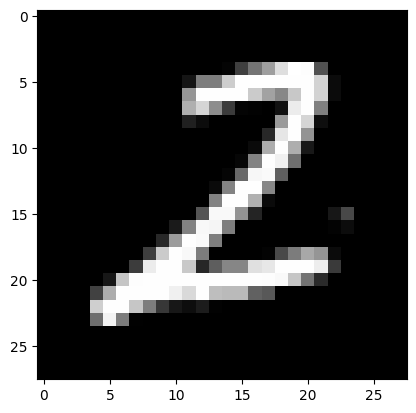

In [75]:
plt.imshow(flat_data[90].reshape(28, 28), cmap='gray');
plt.show()


In [84]:
def apply_blur(image, kernal_size=(3,3)):
  blurred_img = cv2.GaussianBlur(image,kernal_size,0)
  blurred_img = cv2.blur(blurred_img,kernal_size)
  return blurred_img

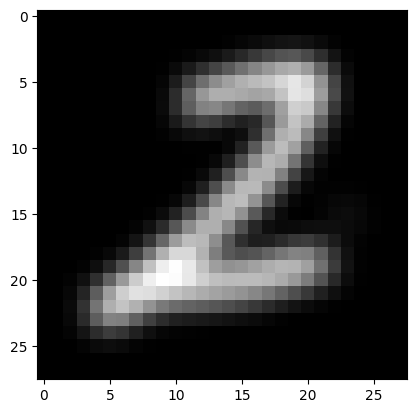

In [85]:
plt.imshow(apply_blur(flat_data[90].reshape(28, 28)), cmap='gray')

In [10]:
transformed_imgs = []

for image in range(flat_data.shape[0]):
  blurred_image = apply_blur(flat_data[image].reshape(28, 28))
  transformed_imgs.append(blurred_image.reshape(-1))

transformed_imgs = np.array(transformed_imgs)

In [11]:
transformed_imgs.shape

(10740, 784)

In [12]:
# dimensionality reduction where 90% data is retained
pca = PCA(n_components=0.90)
reduced_data = pca.fit_transform(transformed_imgs)

In [13]:
reduced_data.shape

(10740, 24)

In [14]:
#Visualising high-dimensional data into lower dimensional (2D)
tsne = TSNE(n_components=2, n_iter=5000, n_iter_without_progress=250, perplexity=20, early_exaggeration=25)
lower_dimension_data = tsne.fit_transform(reduced_data)

In [15]:
lower_dimension_data.shape

(10740, 2)

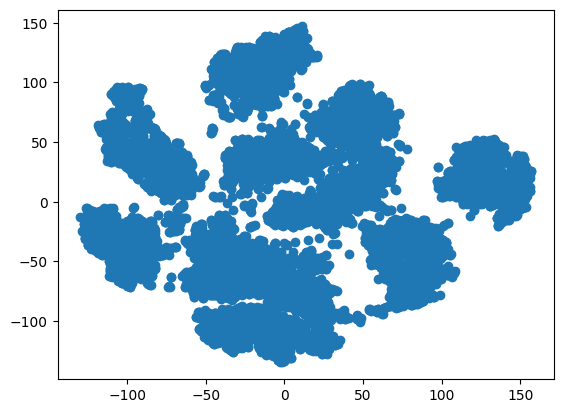

In [16]:
plt.scatter(lower_dimension_data[:,0], lower_dimension_data[:,1])

In [ ]:
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(reduced_data)

In [66]:
ms = MinMaxScaler(feature_range=(1,1000))
scaled_data = ms.fit_transform(lower_dimension_data)

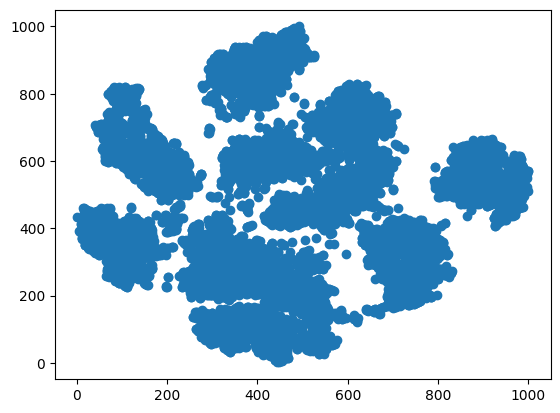

In [67]:
plt.scatter(scaled_data[:,0], scaled_data[:,1])

In [68]:
data = scaled_data

In [30]:
def generateRandomKCentroids(data,k):
  random_indices = np.random.randint(0,data.shape[0], size=(k,))
  centroids = data[random_indices, :]
  return centroids

In [31]:
def assignClusters(data, centroids):
  distances = np.linalg.norm(data[:,np.newaxis,:] - centroids, axis=2)
  clusters = np.argmin(distances, axis=1)
  return clusters

In [ ]:
# generateRandomKCentroids(data,10)

In [ ]:
# centroids = generateRandomKCentroids(data, 10)
# clusters = assignClusters(data, centroids)

In [ ]:
# plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', alpha=0.5, label='Data Points')
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

In [32]:
def updateCentroids(data, clusters, numClusters):
    newCentroids = np.array([data[clusters == k].mean(axis=0) for k in range(numClusters)])
    return newCentroids

In [ ]:
# updateCentroids(data, clusters, 10)

In [23]:
def reinitializeEmptyClusters(data, clusters, centroids):
    unique_clusters, counts = np.unique(clusters, return_counts=True)

    # Find empty clusters
    empty_clusters = unique_clusters[counts == 0]

    # Reinitialize empty clusters
    for empty_cluster in empty_clusters:
        # Find the cluster with the maximum number of assigned data points
        non_empty_clusters = unique_clusters[counts > 0]
        max_non_empty_cluster = non_empty_clusters[np.argmax(counts[counts > 0])]

        # Assign data points from the non-empty cluster to the empty cluster
        indices_non_empty = np.where(clusters == max_non_empty_cluster)[0]
        indices_empty = np.where(clusters == empty_cluster)[0]

        # Update centroids for the empty cluster
        centroids[empty_cluster] = np.mean(data[indices_non_empty], axis=0)

        # Update counts for non-empty and empty clusters
        counts[max_non_empty_cluster] -= len(indices_empty)
        counts[empty_cluster] += len(indices_empty)

    return centroids


In [ ]:
# def kMeans(data, numClusters, maxIterations=500):
#   centroids = generateRandomKCentroids(data, numClusters)

#   for i in range(maxIterations):
#     clusters = assignClusters(data, centroids)
#     newCentroids = updateCentroids(data, clusters, numClusters)
#     centroids = reinitializeEmptyClusters(data, clusters, newCentroids)

#     if np.all(centroids == newCentroids):
#       break

#     centroids = newCentroids

#   return clusters, centroids

In [49]:
def kMeans(data, numClusters, maxIterations=500, tolerance=1e-4):
  centroids = generateRandomKCentroids(data, numClusters)

  for i in range(maxIterations):
    clusters = assignClusters(data, centroids)
    newCentroids = updateCentroids(data, clusters, numClusters)

    if np.linalg.norm(newCentroids - centroids) < tolerance:
        break

    centroids = newCentroids

  return clusters, centroids

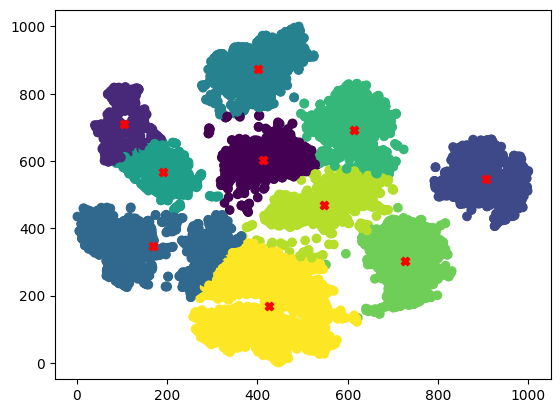

In [50]:
final_clusters, final_centroids = kMeans(data, 10,500)

plt.scatter(data[:, 0], data[:, 1], c=final_clusters, cmap='viridis', label='Data Points')
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], c='red', marker='X', label='Centroids')

In [54]:
def cal_inertia(data, centroids, clusters):
  inertia = 0
  for i in range(len(centroids)):
    clusters_points = data[clusters == i]
    distances = np.sum((clusters_points - centroids[i])**2,axis=1)
    inertia += np.sum(distances)
  return inertia

In [55]:
k_values = range(2, 21, 2)


In [ ]:
# def calc_inertia(data, k_values):
#   inertia_values=[]
#   for k in k_values:
#     final_clusters, final_centroids = kMeans(data, k)
#     inertia = cal_inertia(data, final_centroids, final_clusters)
#     inertia_values.append(inertia)
#   return inertia_values

In [57]:
# inertia_values = calc_inertia(data, k_values)
inertia_values = [calc_inertia(data, *kMeans(data, k)) for k in k_values]

plt.plot(k_values, inertia_values, marker='o')
plt.title('Internal Evaluation Metric (Inertia) vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

IndexError: ignored

In [ ]:

for k, inertia in zip(k_values, inertia_values):
    print(f'Number of Clusters: {k}, Inertia: {inertia}')

Number of Clusters: 2, Inertia: 721949120.0
Number of Clusters: 4, Inertia: 281007588.0
Number of Clusters: 6, Inertia: 175678269.0
Number of Clusters: 8, Inertia: 114874660.0
Number of Clusters: 10, Inertia: 81437686.5
Number of Clusters: 12, Inertia: 70698998.5
Number of Clusters: 14, Inertia: 56826172.125
Number of Clusters: 16, Inertia: 54878458.25
Number of Clusters: 18, Inertia: 47196104.0
Number of Clusters: 20, Inertia: 45546368.34375


In [ ]:
def calculate_silhouette_score(data, k_values):
  silhouette_scores = []

  for k in k_values:
    final_clusters, final_centroids = kMeans(data, k)
    silhouette = silhouette_score(data, final_clusters)
    silhouette_scores.append(silhouette)

  return silhouette_scores

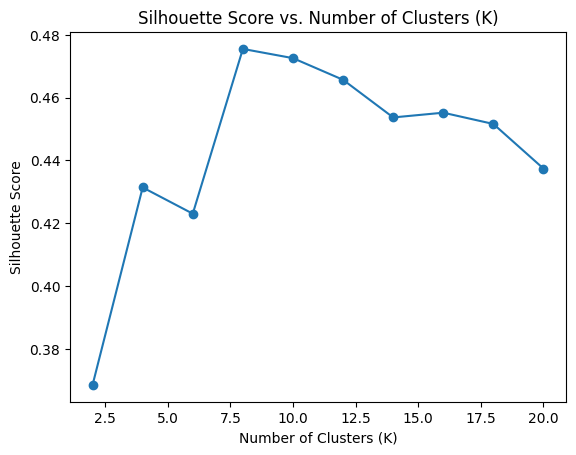

In [ ]:
silhouette_scores = calculate_silhouette_score(data, k_values)

# Plot the silhouette scores against the number of clusters (K)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
K = 10
final_clusters, _ = kMeans(data, K)

result_df = pd.DataFrame(final_clusters + 1)
result_df.to_csv('cluster_assignments.txt', index=False, header=False, sep=' ')